### Reference: [Andrej Karpathy YouTube video Link](https://www.youtube.com/watch?v=P6sfmUTpUmc)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    # for w in words[:5]:
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# Case: when we don't multiply with 0 in b2 and 0.01 in W2
# Note: try without multiplying with 0 and 0.01; you'll notice
# the loss value is initially very high and drops down to a very low value
# this will happen because our model was improperly configured at initialization
# because the 1st iteration loss results is very high

# we always have a rough idea about how much loss we'd accept
# in our case, we accept very less loss
# we have 27 characters, so every character should have an equal probability
# i.e., will have expected prob to be 1/27
# here, in our case neural network is treating some characters very strong and some very weak

In [7]:
# expected loss

-torch.tensor(1/27.0).log()

tensor(3.2958)

In [8]:
# toy example

# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])  # try chaning values and check loss
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()  # expected loss
probs, probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [9]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  # scaling down
b1 = torch.randn(n_hidden, generator=g) * 0.01  # scaling down to save activation from 1 and -1 values
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # scaling down
b2 = torch.randn(vocab_size, generator=g) * 0  # multiply by 0: to ensure b2 is 0 during initialization

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [11]:
# these logits must be closer to zero
logits[0]

tensor([-2.6747,  2.1231, -0.6957, -0.1797,  0.2563,  2.4494, -1.8891, -2.4445,
        -1.0200,  2.9168, -2.3774, -0.5807,  3.0092,  1.9834,  3.8758,  1.2065,
        -0.8338, -3.8639,  1.6995,  1.6316,  0.5563, -2.8112,  0.3735, -2.5028,
        -2.7555,  2.9825, -0.0862], grad_fn=<SelectBackward0>)

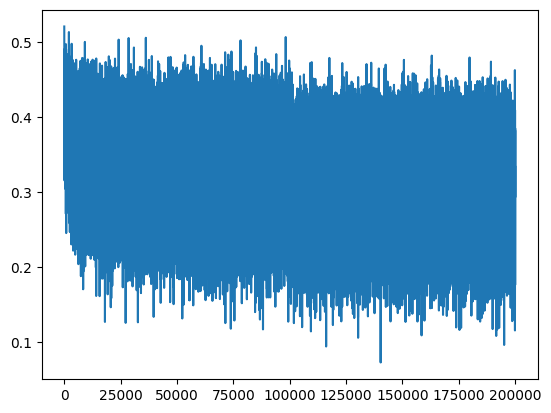

In [12]:
plt.plot(lossi)

In [13]:
# the second problem is with the activation function
# activations of the hidden state
# notice many values are either 1 or -1; this is because of tanh
h

tensor([[ 0.9471,  0.9467, -0.9594,  ..., -0.9875, -0.0688,  0.9301],
        [ 0.9999, -0.1997, -0.9872,  ..., -0.9991,  0.7278,  0.8696],
        [-0.8056,  0.9884, -0.9419,  ..., -0.0269, -0.9978,  0.4375],
        ...,
        [-0.1267, -0.9547, -0.7422,  ..., -0.6853, -0.2289, -0.4154],
        [-0.0147,  0.6083,  0.9824,  ..., -0.1743,  0.3367,  0.9421],
        [ 0.1327, -0.5583, -1.0000,  ..., -0.7272, -0.9789,  0.9251]],
       grad_fn=<TanhBackward0>)

(array([ 959.,  218.,  145.,  120.,  103.,  102.,   72.,   85.,   75.,
          70.,   69.,   74.,   69.,   68.,   76.,   65.,   49.,   77.,
          49.,  105.,   90.,   91.,  107.,   87.,   92.,  124.,  133.,
         101.,  101.,  120.,   71.,   86.,   60.,   73.,   44.,   73.,
          55.,   59.,   37.,   63.,   64.,   59.,   81.,   76.,   78.,
         133.,  130.,  143.,  261., 1058.]),
 array([-1.00000000e+00, -9.60000001e-01, -9.20000002e-01, -8.80000004e-01,
        -8.40000005e-01, -8.00000006e-01, -7.60000007e-01, -7.20000008e-01,
        -6.80000010e-01, -6.40000011e-01, -6.00000012e-01, -5.60000013e-01,
        -5.20000014e-01, -4.80000015e-01, -4.40000017e-01, -4.00000018e-01,
        -3.60000019e-01, -3.20000020e-01, -2.80000021e-01, -2.40000023e-01,
        -2.00000024e-01, -1.60000025e-01, -1.20000026e-01, -8.00000274e-02,
        -4.00000286e-02, -2.98023224e-08,  3.99999690e-02,  7.99999678e-02,
         1.19999967e-01,  1.59999965e-01,  1.99999964e-01,  2.399999

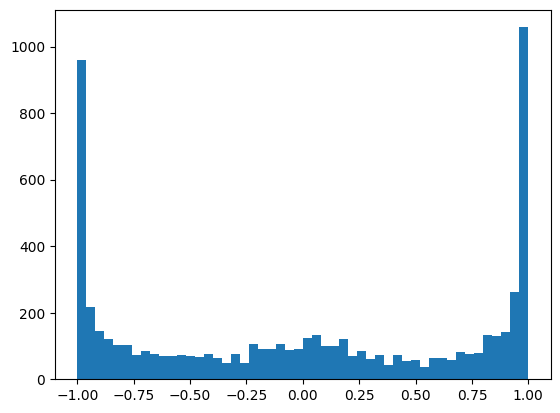

In [14]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   3.,   3.,   3.,   4.,   6.,  11.,   9.,  18.,
         16.,  31.,  38.,  41.,  60.,  86., 120., 158., 160., 222., 231.,
        279., 367., 463., 711., 904., 400., 327., 320., 275., 250., 213.,
        188., 115.,  87.,  70.,  55.,  35.,  30.,  32.,  19.,  16.,   4.,
          4.,   4.,   6.,   4.,   0.,   1.]),
 array([-9.74661446, -9.37275055, -8.99888664, -8.62502274, -8.25115883,
        -7.87729492, -7.50343102, -7.12956711, -6.7557032 , -6.38183929,
        -6.00797539, -5.63411148, -5.26024757, -4.88638367, -4.51251976,
        -4.13865585, -3.76479195, -3.39092804, -3.01706413, -2.64320023,
        -2.26933632, -1.89547241, -1.52160851, -1.1477446 , -0.77388069,
        -0.40001678, -0.02615288,  0.34771103,  0.72157494,  1.09543884,
         1.46930275,  1.84316666,  2.21703056,  2.59089447,  2.96475838,
         3.33862228,  3.71248619,  4.0863501 ,  4.460214  ,  4.83407791,
         5.20794182,  5.58180573,  5.95566963,  6.32953354,  6.70339745,
 

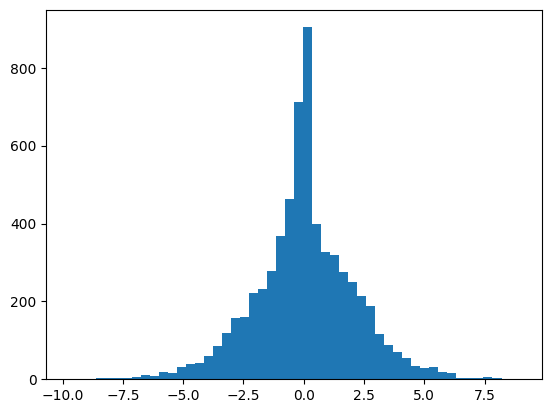

In [15]:
# distribution is very broad
plt.hist(hpreact.view(-1).tolist(), 50)

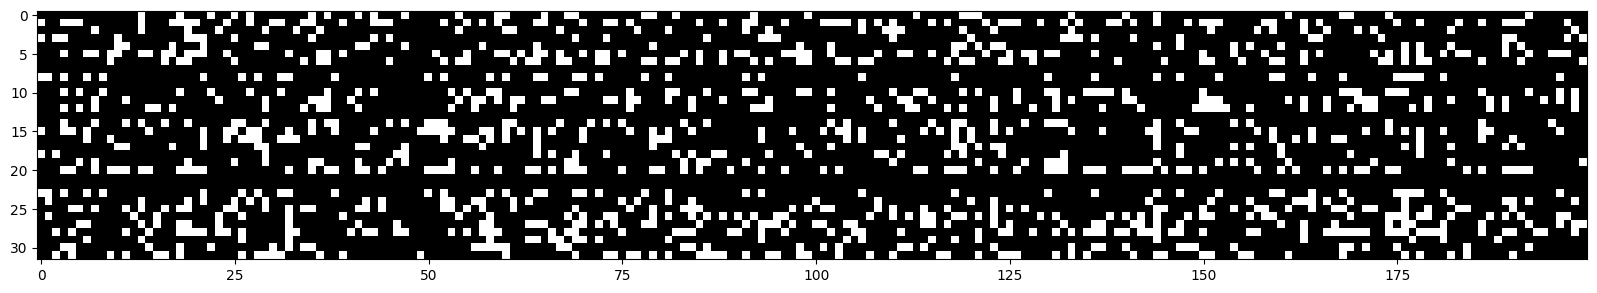

In [16]:
# the white places tell us tanh neurons are very active,
# and backward gradient would get destroyed
# If, in any case, a complete line is white, it'll be a case of a dead neuron (a neuron never learns)

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [17]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, bloack_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# we get comparatively low losses because we are now spending more time optimizing our model
# rather than squeezing the weight values

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102677822113037


In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


In [19]:
# optimizing

tensor(-0.0222) tensor(1.0251)
tensor(0.0003) tensor(1.0251)


(array([4.33018056e-05, 8.66036113e-05, 6.49527084e-05, 1.51556320e-04,
        4.54668959e-04, 7.14479793e-04, 8.44385210e-04, 1.29905417e-03,
        2.66306105e-03, 3.57239896e-03, 6.01895098e-03, 9.26658640e-03,
        1.44195013e-02, 2.16725537e-02, 3.40135683e-02, 5.10744797e-02,
        7.48471710e-02, 1.08600929e-01, 1.49586088e-01, 2.03258676e-01,
        2.61023284e-01, 3.26820378e-01, 3.81705417e-01, 4.14311676e-01,
        4.25050524e-01, 4.03204763e-01, 3.55507824e-01, 2.92092330e-01,
        2.26013774e-01, 1.73943353e-01, 1.24687549e-01, 9.01760102e-02,
        5.99946517e-02, 3.96861049e-02, 2.70203267e-02, 1.72990713e-02,
        1.06955460e-02, 6.53857265e-03, 4.84980223e-03, 3.09607910e-03,
        1.60216681e-03, 9.09337918e-04, 5.84574376e-04, 3.24763542e-04,
        2.38159931e-04, 4.33018056e-05, 6.49527084e-05, 2.16509028e-05,
        0.00000000e+00, 2.16509028e-05]),
 array([-5.59271097, -5.36177372, -5.13083647, -4.89989922, -4.66896196,
        -4.43802471, 

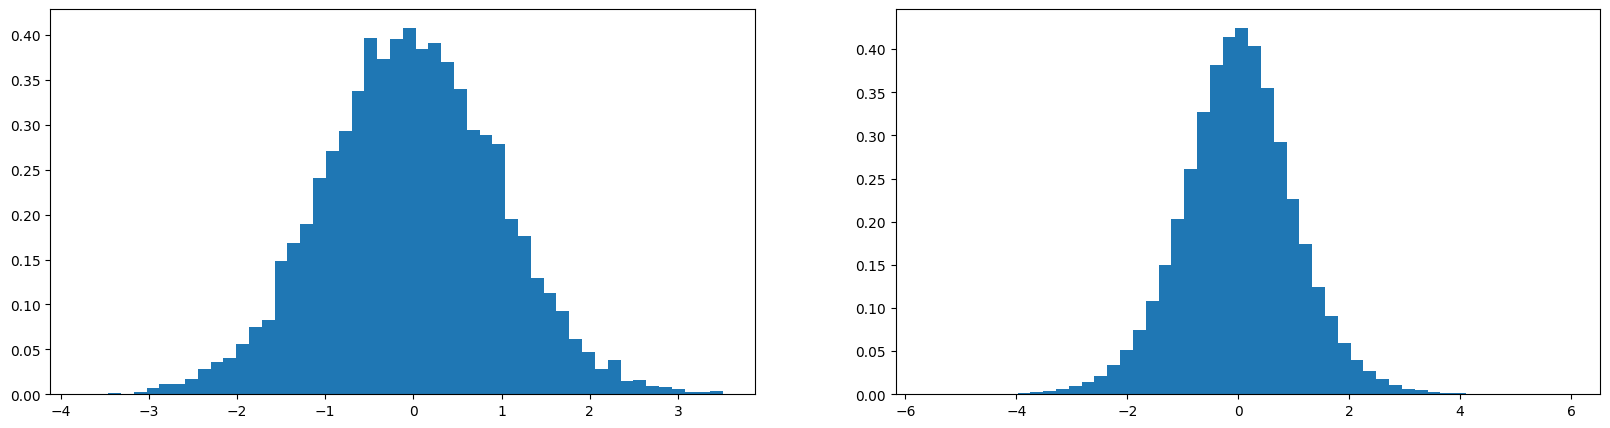

In [20]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5  # change the multiplicative factor to see how the Gaussian area changes
# what to multiply to preserve standard deviation to 1
# one way is to divide by the square root of the number of inputs as above

y = x @ w
print(x.mean(), y.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [21]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# why multiply 5/3?
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
# For tanh: gain is 5/3
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5  # scaling down
b1 = torch.randn(n_hidden, generator=g) * 0.01  # scaling down to save activation from 1 and -1 values
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # scaling down
b2 = torch.randn(vocab_size, generator=g) * 0  # multiply by 0: to ensure b2 is 0 during initialization

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [23]:
# We'll get nearly same results in this case

@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, bloack_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# we get comparatively low losses because we are now spending more time optimizing our model
# rather than squeezing the weight values

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [24]:
# Using batch normalization
#    - stabalize training
#    - regularizing effect
#    - first method to improve training
#    - used to control the statistics in neural networks
#    - we usually use it after the linear layer

In [25]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# why multiply 5/3?
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
# For tanh: gain is 5/3
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5  # scaling down

# since, we have batch normalization bias, we don't need this (it'll be useless even if we uncomment it)
# We do bias=False; for the same reason
# b1 = torch.randn(n_hidden, generator=g) * 0.01  # scaling down to save activation from 1 and -1 values

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # scaling down
b2 = torch.randn(vocab_size, generator=g) * 0  # multiply by 0: to ensure b2 is 0 during initialization

# multiplication and addition factor to make Gaussian distribution flexible; otherwise, it won't have good results
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [26]:
hpreact.shape

torch.Size([32, 200])

In [27]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [28]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors

    # we don't want these hidden states to be too small or too large
    # Batch norm paper says we have the hidden state; we just have to normalize them to make it Gaussian distribution
    hpreact = embcat @ W1 # + b1  # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


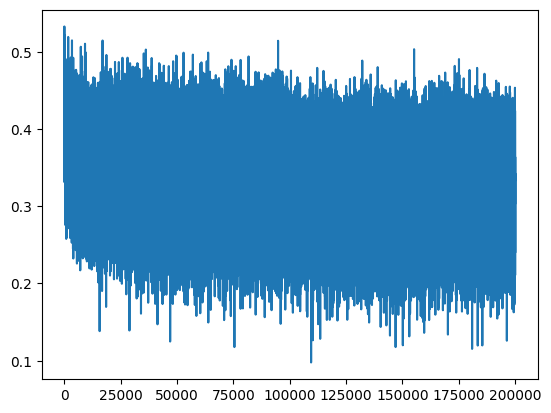

In [30]:
plt.plot(lossi)

In [31]:
# we don't need this to be written explicitly
# nobody wants to write the training steps again and again
# so, the batch norm paper introduced a way
# (see above training code)


# calibrate the batch norm at the end of the training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [32]:
bnmean

tensor([[-2.4533e+00,  4.1450e-01, -1.4185e+00,  1.7016e+00,  1.0438e+00,
          5.5779e-01,  2.1393e+00, -1.7456e+00,  1.1730e+00,  1.6132e+00,
         -2.1092e+00, -2.9678e+00,  8.9084e-02, -7.4119e-01,  3.8174e-01,
         -8.0180e-01,  7.2180e-01, -2.7978e+00, -4.3718e-01,  2.0177e+00,
         -8.3362e-01, -8.5357e-02,  5.1530e-02,  3.9957e-01,  1.1621e+00,
          1.4650e+00,  1.1876e+00,  8.2047e-01,  5.0620e-01,  2.0325e+00,
         -4.6832e-01, -1.3510e+00,  4.2573e-02, -5.1512e-01, -3.0540e-01,
         -1.8657e+00, -2.3723e+00, -2.0418e-01, -5.4103e-01,  4.6374e-01,
         -1.6117e-01, -1.0511e+00, -2.0274e-01, -1.5614e-01,  8.1102e-01,
          6.0230e-01,  1.3442e+00, -9.1654e-02,  2.3045e+00,  1.1668e+00,
          1.6326e+00, -8.3694e-01,  2.2629e+00,  3.5629e-01,  7.1999e-01,
         -2.0908e+00, -1.3222e-01,  1.2056e+00,  7.4815e-01, -9.6874e-01,
         -5.5621e-01,  1.1906e+00,  7.0419e-01,  2.8163e-02,  1.4436e+00,
          1.7318e+00, -1.1168e+00,  2.

In [33]:
bnmean_running

tensor([[-2.4073e+00,  3.7329e-01, -1.2681e+00,  1.2967e+00,  9.6879e-01,
          9.8374e-01,  1.5422e+00, -1.9247e+00,  1.1060e+00,  1.2247e+00,
         -1.8296e+00, -2.7717e+00,  7.1372e-02, -6.1822e-01,  4.3366e-01,
         -6.6872e-01,  7.7061e-01, -2.1880e+00, -2.1888e-01,  1.5707e+00,
         -8.6628e-01,  1.0770e-01, -2.3913e-01,  4.1436e-01,  1.0355e+00,
          1.6324e+00,  1.1980e+00,  9.5800e-01,  3.5300e-01,  1.9479e+00,
         -8.0373e-02, -1.2021e+00, -9.8009e-02, -2.6651e-01, -4.7078e-01,
         -1.4911e+00, -2.6119e+00,  4.6955e-02, -3.1134e-04,  6.0432e-01,
         -2.3634e-01, -9.1246e-01, -2.8293e-01, -1.7836e-01,  6.5021e-01,
          9.0387e-01,  1.5864e+00, -3.9491e-01,  1.9726e+00,  1.0563e+00,
          1.7167e+00, -7.9530e-01,  2.0450e+00,  3.5585e-01,  5.4984e-01,
         -1.9198e+00, -3.1742e-02,  7.1272e-01,  9.0174e-01, -7.9929e-01,
         -6.7666e-01,  9.6928e-01,  4.8909e-01,  2.9598e-01,  1.1424e+00,
          1.6292e+00, -1.3297e+00,  2.

In [34]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, bloack_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# we get comparatively low losses because we are now spending more time optimizing our model
# rather than squeezing the weight values

split_loss('train')
split_loss('val')

train 2.103177547454834
val 2.13948655128479


In [35]:
# SUMMARY ----------

In [36]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        # when using batchnorm; it's not necessary to divide by fan_in**0.5
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10  # dimensionality of the character embedding vectors
n_hidden = 100  # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, n_hidden), Tanh(),
#     Linear(           n_hidden, vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1  # without BatchNorm
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2  # 5/3  # use 0.2; when using batchnorm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [37]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # update

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y
  
    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    # iterate with different values to observe the graph variations
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3179
  20000/ 200000: 2.0484
  30000/ 200000: 1.9379
  40000/ 200000: 2.2128
  50000/ 200000: 2.2116
  60000/ 200000: 1.7690
  70000/ 200000: 2.1968
  80000/ 200000: 2.3733
  90000/ 200000: 1.9752
 100000/ 200000: 2.3535
 110000/ 200000: 2.1379
 120000/ 200000: 2.1194
 130000/ 200000: 1.9506
 140000/ 200000: 1.7644
 150000/ 200000: 1.8907
 160000/ 200000: 2.0264
 170000/ 200000: 1.8894
 180000/ 200000: 2.2238
 190000/ 200000: 1.9391


layer 2 (      Tanh): mean -0.01, std 0.72, saturated: 19.09%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 21.47%
layer 8 (      Tanh): mean -0.01, std 0.76, saturated: 17.41%
layer 11 (      Tanh): mean -0.03, std 0.76, saturated: 15.62%
layer 14 (      Tanh): mean -0.03, std 0.78, saturated: 16.03%


Text(0.5, 1.0, 'activation distribution')

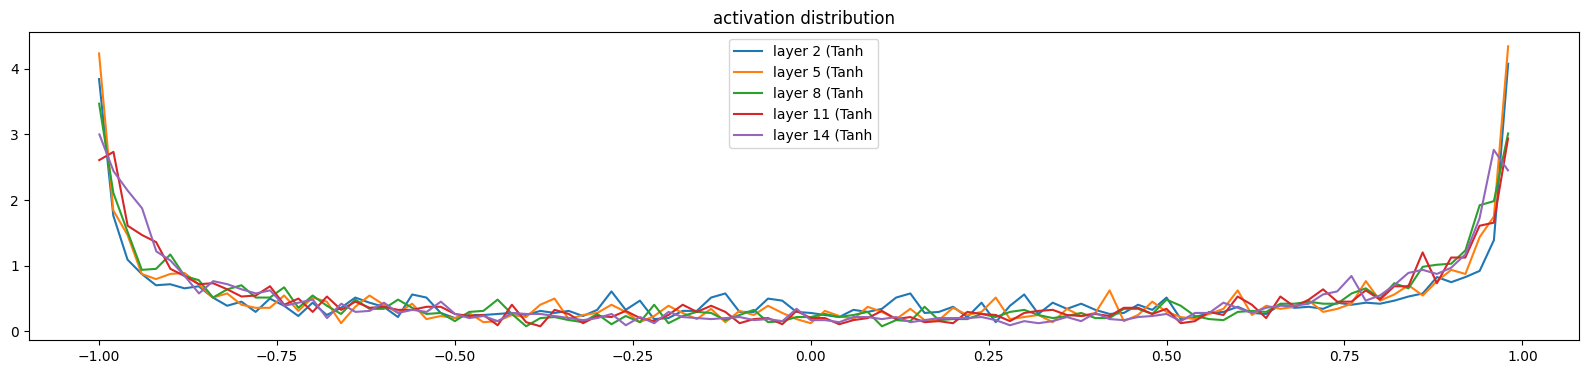

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.659379e-03
layer 5 (      Tanh): mean -0.000000, std 3.803218e-03
layer 8 (      Tanh): mean +0.000000, std 3.226713e-03
layer 11 (      Tanh): mean +0.000000, std 2.859497e-03
layer 14 (      Tanh): mean +0.000000, std 3.437317e-03


Text(0.5, 1.0, 'gradient distribution')

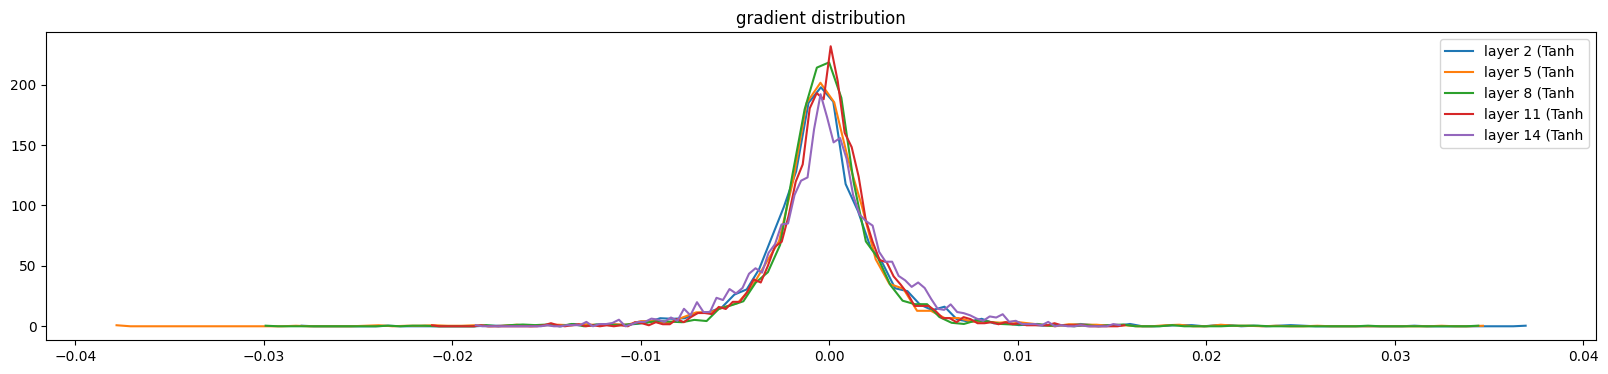

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.561950e-02 | grad:data ratio 1.451630e-02
weight  (30, 100) | mean +0.000121 | std 1.068159e-02 | grad:data ratio 3.223863e-02
weight (100, 100) | mean +0.000017 | std 7.073311e-03 | grad:data ratio 3.815167e-02
weight (100, 100) | mean +0.000071 | std 6.639715e-03 | grad:data ratio 4.025672e-02
weight (100, 100) | mean -0.000106 | std 6.019276e-03 | grad:data ratio 4.073166e-02
weight (100, 100) | mean -0.000056 | std 5.175254e-03 | grad:data ratio 3.546049e-02
weight  (100, 27) | mean +0.000081 | std 8.776677e-03 | grad:data ratio 3.084059e-02


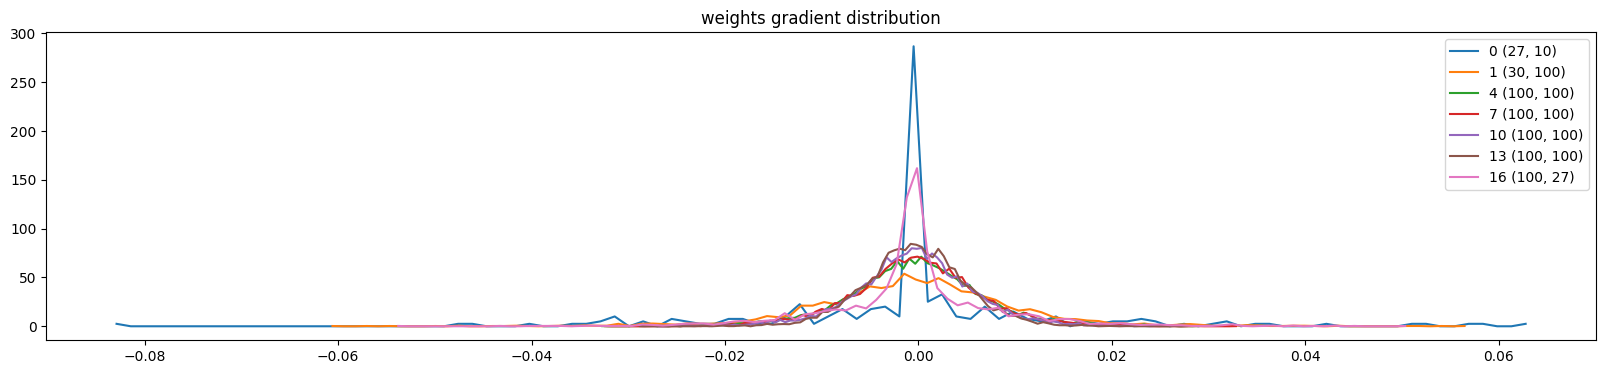

In [40]:
# Note:
# step update = learning rate * gradient
# if the grad is too large, we'll be in trouble
# last layer is in trouble

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

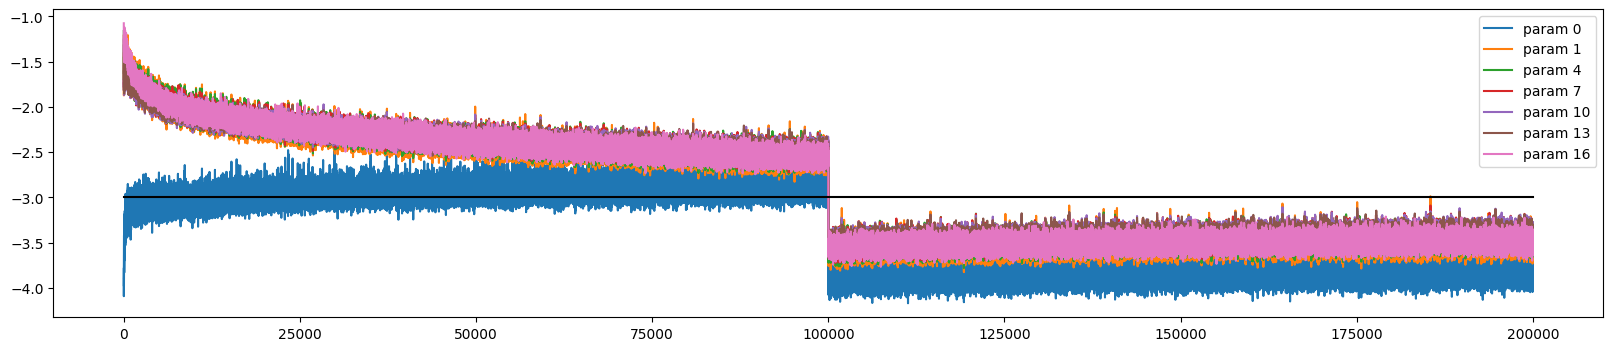

In [41]:
# plotting update ratios

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 2.0196335315704346
val 2.087184190750122


In [43]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
med.
ryla.
reisa.
jendraegendered.
eliah.
milopileigh.
van.
aarielle.
malaia.
noshub.
ridhimie.
trick.
welle.
jetta.
fius.
kace.
ryyah.
fael.
